In [1]:
import numpy as np
import dolfin as dl
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
from scipy.spatial import cKDTree
from nalger_helper_functions import *

In [2]:
# n = 25
# mesh = dl.UnitSquareMesh(n,n)

mesh_center = np.array([0.5, 0.5])
mesh_radius = 0.5
mesh_h = 3e-2 # 2.5e-2 # 1e-2
mesh = circle_mesh(mesh_center, mesh_radius, mesh_h)

V = dl.FunctionSpace(mesh, 'CG', 1)
dof_coords = V.tabulate_dof_coordinates()

u_trial = dl.TrialFunction(V)
v_test = dl.TestFunction(V)

derivative_direction = np.array([1., 0.5])

xhat = dl.Expression(("a", "b"), a=derivative_direction[0], b=derivative_direction[1],
                     domain=mesh, degree=5)
Dx_true = csr_fenics2scipy(dl.assemble(v_test * dl.inner(xhat, dl.grad(u_trial)) * dl.dx))
Dx_true = Dx_true + 0.0 * (1j * Dx_true)

M = csr_fenics2scipy(dl.assemble(u_trial * v_test * dl.dx))
M = M + 0.0 * (1j * M)
solve_M = spla.factorized(M)

Dx_true_coo = Dx_true.tocoo()

# Dx_true_dense = Dx_true.toarray()

q_true = Dx_true_coo.data.real
rows_true = Dx_true_coo.row
cols_true = Dx_true_coo.col

nq_true = len(q_true)
print('nq_true=', nq_true)

print('V.dim()=', V.dim())

print(nq_true / (V.dim()**2))

nq_true= 14910
V.dim()= 2214
0.0030417422512075167


/home/nick/anaconda3/envs/fenics3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


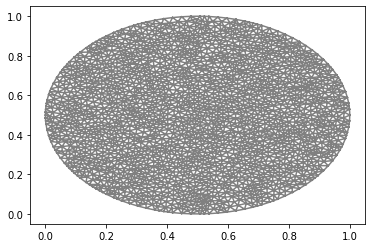

In [3]:
dl.plot(mesh)

min_h= 0.014957733084699098 , mesh_diameter= 1.4139762015339827
nnz= 22140 , np.size(X)= 19926
s= 1e-07 , err_D_prime_mode3_contraction= 1.793489379476528e-09
s= 1e-15 , err_grad= 1.0052451262026953 , err_hess= 0.1458834607702617
s= 1e-14 , err_grad= inf , err_hess= 0.015202043133210686
s= 1e-13 , err_grad= inf , err_hess= 0.001506316079783499
s= 1e-12 , err_grad= 1.0980504810781448 , err_hess= 0.00014961421538943842
s= 1e-11 , err_grad= 0.00867811590295429 , err_hess= 1.5109247711724284e-05
s= 1e-10 , err_grad= 2.406152437794179e-05 , err_hess= 1.522034074350585e-06
s= 1e-09 , err_grad= 7.126056708372802e-05 , err_hess= 1.5979695227259068e-07
s= 1e-08 , err_grad= 3.313391124200624e-05 , err_hess= 1.6633276753216256e-08
s= 1e-07 , err_grad= 5.948928544155004e-06 , err_hess= 1.6679511074625908e-09
s= 1e-06 , err_grad= 7.916598175996822e-05 , err_hess= 1.6691145605787962e-10
s= 1e-05 , err_grad= 0.0007930025579352771 , err_hess= 1.6564364126842374e-11
s= 0.0001 , err_grad= 0.007987148466

/home/nick/repos/nalger_helper_functions/nalger_helper_functions/least_squares_derivative_matrix.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  Y_true[:,k] = apply_D_true(X[:,k])
/home/nick/repos/nalger_helper_functions/nalger_helper_functions/least_squares_derivative_matrix.py:235: RuntimeWarning: divide by zero encountered in double_scalars
  err_grad = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)


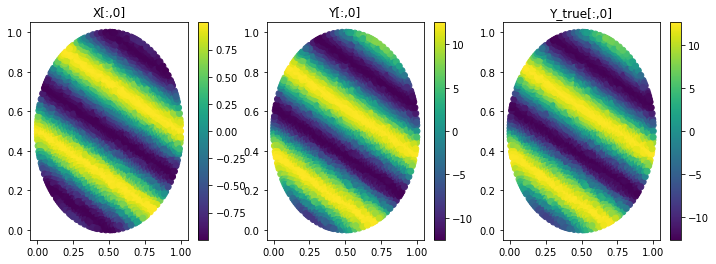

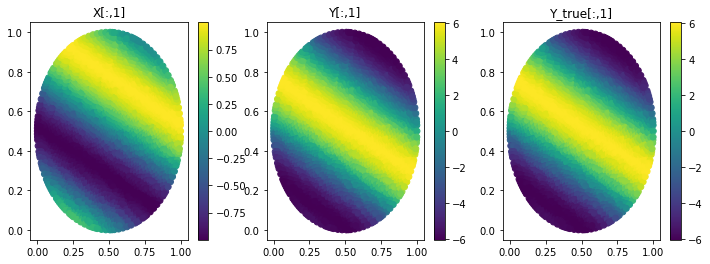

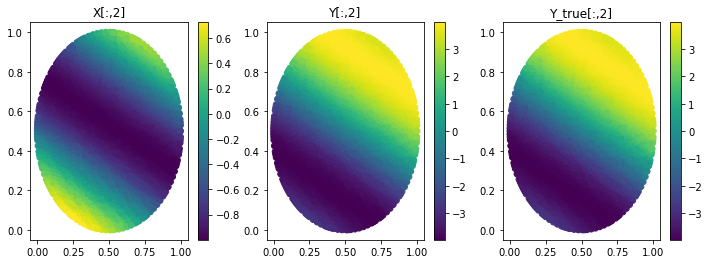

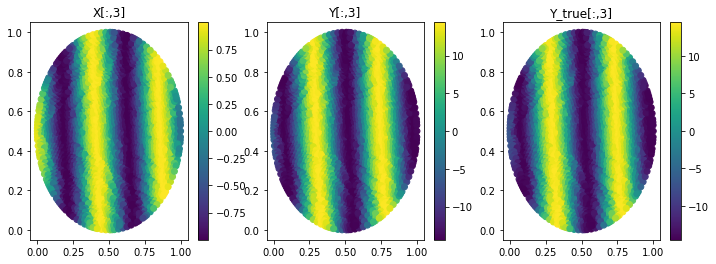

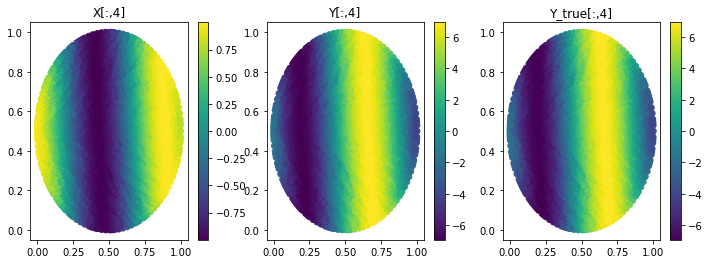

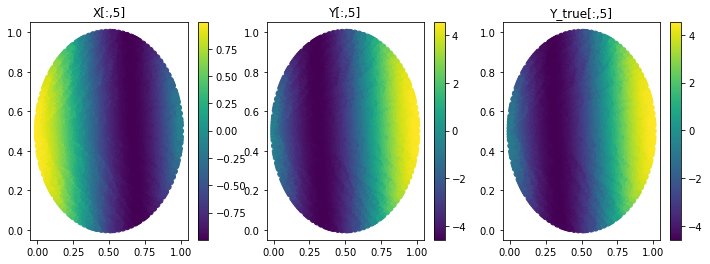

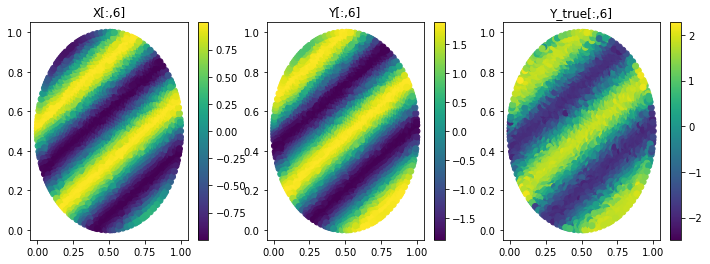

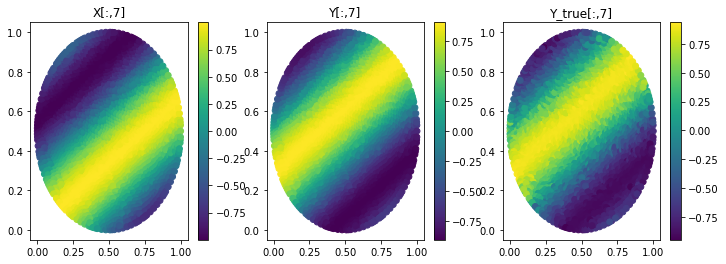

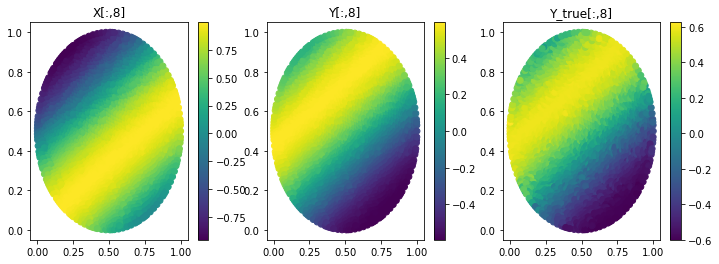

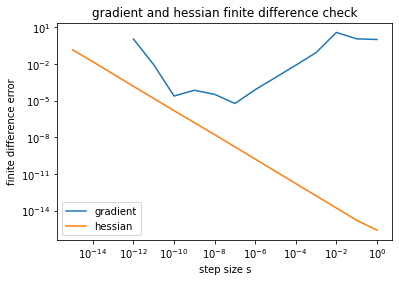

In [4]:
Dx = least_squares_directional_derivative_matrix(dof_coords, derivative_direction,
                                                 a_reg=1e-6, num_neighbors=10,
                                                 num_angles=3, num_frequencies=3,
                                                 min_points_per_wavelength=30,
                                                 plot_probing_functions=True,
                                                 apply_D_true=lambda x: solve_M(Dx_true * x),
                                                 run_finite_difference_checks=True)

err_df_dx= 0.0389628781601037


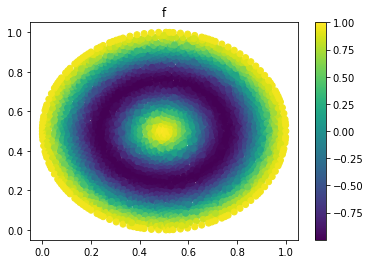

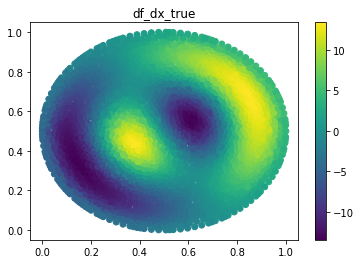

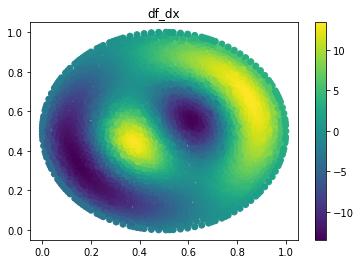

In [5]:
f = np.cos(12 * np.linalg.norm(dof_coords - 0.5, axis=1))

df_dx_true = solve_M(Dx_true.real * f).real
df_dx = (Dx.real * f).real

err_df_dx = np.linalg.norm(df_dx_true - df_dx) / np.linalg.norm(df_dx_true)
print('err_df_dx=', err_df_dx)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=f)
plt.title('f')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_true)
plt.title('df_dx_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx)
plt.title('df_dx')
plt.colorbar()

err_df_dx= 0.04617725497054034


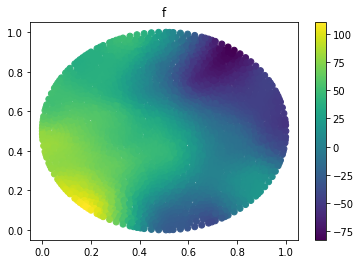

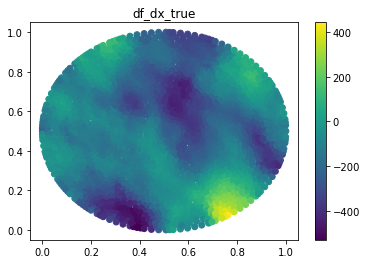

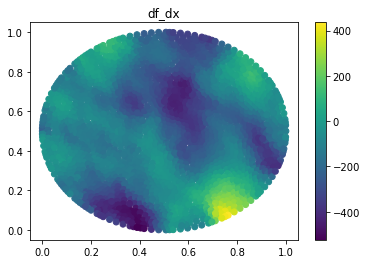

In [6]:
A = csr_fenics2scipy(dl.assemble(dl.inner(dl.grad(u_trial), dl.grad(v_test))*dl.dx + 100.*u_trial*v_test*dl.dx))

f = spla.spsolve(A * A, np.random.randn(V.dim()))

df_dx_true = solve_M(Dx_true.real * f).real
df_dx = (Dx.real * f).real

err_df_dx = np.linalg.norm(df_dx_true - df_dx) / np.linalg.norm(df_dx_true)
print('err_df_dx=', err_df_dx)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=f)
plt.title('f')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_true)
plt.title('df_dx_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx)
plt.title('df_dx')
plt.colorbar()

err_df_dx= 0.45467114169424044


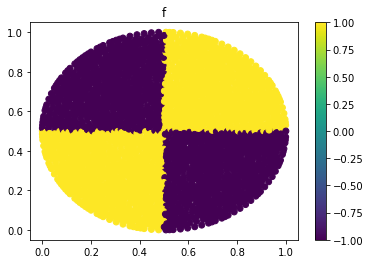

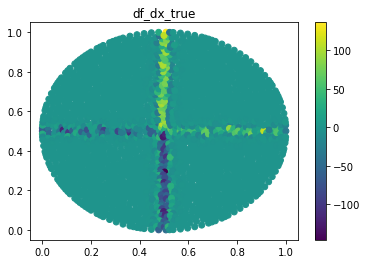

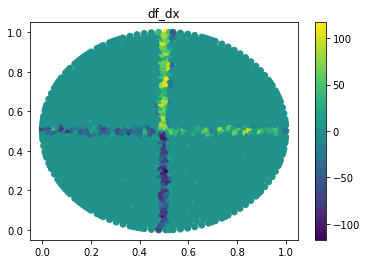

In [7]:
f1 = 2. * (dof_coords[:,0] > 0.5) - 1
f2 = 2. * (dof_coords[:,1] > 0.5) - 1
f = f1 * f2

df_dx_true = solve_M(Dx_true.real * f).real
df_dx = (Dx.real * f).real

err_df_dx = np.linalg.norm(df_dx_true - df_dx) / np.linalg.norm(df_dx_true)
print('err_df_dx=', err_df_dx)

plt.scatter(dof_coords[:,0], dof_coords[:,1], c=f)
plt.title('f')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx_true)
plt.title('df_dx_true')
plt.colorbar()

plt.figure()
plt.scatter(dof_coords[:,0], dof_coords[:,1], c=df_dx)
plt.title('df_dx')
plt.colorbar()
